In [1]:
!module purge
!module load apps/anaconda3
!module load compilers/nvidia/cuda/11.2
!module load compilers/gcc/8.3.0

In [2]:

import cv2
import os
import random

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
import tensorflow as tf
import tensorflow.keras as keras


In [5]:
tf.__version__

'2.7.0'

In [6]:
tf.random.set_seed(42)
np.random.seed(42)


In [7]:
train_dir = "/home/191112024/splited_dataset/AGCCPF/train"
test_dir = "/home/191112024/splited_dataset/AGCCPF/test"
valid_dir = "/home/191112024/splited_dataset/AGCCPF/validate"


In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        )

valid_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        )

Found 5253 images belonging to 3 classes.
Found 1315 images belonging to 3 classes.
Found 1644 images belonging to 3 classes.


In [11]:
from tensorflow.keras import optimizers

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, DepthwiseConv2D
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(x, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    

    
    for repetition in [6,12,24,16]:
    # for repetition in [6,12,24]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
        
    return d


def mobilenet(x):


    def bottleneck_block(x, expand=2048, squeeze=1024):
        m = Conv2D(expand, (1,1),padding="same")(x)
        m = BatchNormalization()(m)
        m = ReLU()(m)
        m = DepthwiseConv2D((3,3),padding='same')(m)
        m = BatchNormalization()(m)
        m = ReLU()(m)
        m = Conv2D(squeeze, (1,1),padding='same')(m)
        m = BatchNormalization()(m)
        return Add()([m, x])
    
    x=bottleneck_block(x)
    # x=bottleneck_block(x)
#     x=bottleneck_block(x)
    return x

input_shape = 224, 224, 3
n_classes = 3
input_ = Input (input_shape)
x = Conv2D(64, 7, strides = 2, padding = 'same')(input_)
x = MaxPool2D(3, strides = 2, padding = 'same')(x)
x = densenet(x)
x=mobilenet(x)

x = GlobalAveragePooling2D()(x)
output = Dense(n_classes, activation = 'softmax')(x)
model=Model(input_,output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [14]:
%cd /content/gdrive/MyDrive/

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/'
/home/191112024


In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model_13.h5", save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True)


In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=250,
                    epochs=300,
                    validation_data=valid_generator,
                    validation_steps=60,
                    callbacks=[checkpoint_cb])


Epoch 1/300
250/250 [==============================] - ETA: 0s - loss: 0.9966 - acc: 0.5203 - recall: 0.3785 - precision: 0.5382

/home/191112024/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


250/250 [==============================] - 638s 2s/step - loss: 0.9966 - acc: 0.5203 - recall: 0.3785 - precision: 0.5382 - val_loss: 1.0733 - val_acc: 0.3208 - val_recall: 0.0608 - val_precision: 0.2829
Epoch 2/300
250/250 [==============================] - 607s 2s/step - loss: 0.9698 - acc: 0.5307 - recall: 0.4130 - precision: 0.5507 - val_loss: 1.1245 - val_acc: 0.2958 - val_recall: 0.2500 - val_precision: 0.3476
Epoch 3/300
250/250 [==============================] - 605s 2s/step - loss: 0.9584 - acc: 0.5390 - recall: 0.4146 - precision: 0.5670 - val_loss: 0.9884 - val_acc: 0.5300 - val_recall: 0.4942 - val_precision: 0.5445
Epoch 4/300
250/250 [==============================] - 609s 2s/step - loss: 0.9468 - acc: 0.5398 - recall: 0.4264 - precision: 0.5720 - val_loss: 1.0920 - val_acc: 0.4958 - val_recall: 0.3050 - val_precision: 0.5199
Epoch 5/300
250/250 [==============================] - 606s 2s/step - loss: 0.9379 - acc: 0.5416 - recall: 0.4296 - precision: 0.5718 - val_loss: 0.

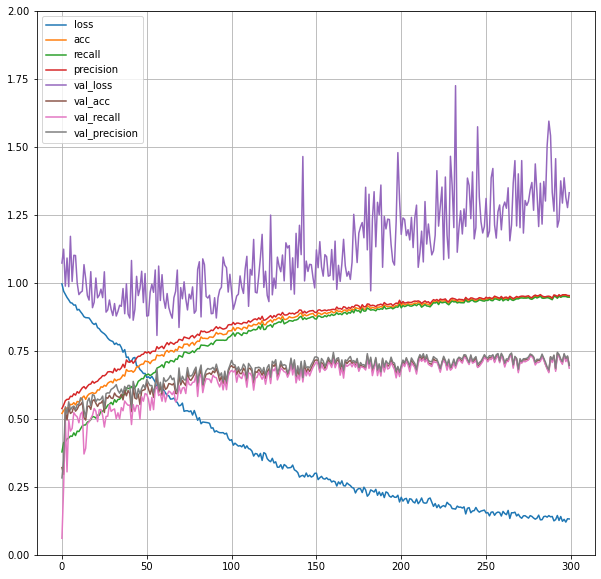

In [17]:
pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.ylim((0,2))
plt.grid(True)
plt.show()

In [18]:
model.evaluate(test_generator)

83/83 [==============================] - 22s 258ms/step - loss: 1.2729 - acc: 0.7026 - recall: 0.6971 - precision: 0.7074


[1.272915244102478, 0.7025547623634338, 0.6970803141593933, 0.7074074149131775]

In [19]:
x=model.predict(train_generator)
actual=train_generator.labels
pred=np.argmax(x, axis=-1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[ 161,  497,  263],
       [ 511, 1397,  872],
       [ 267,  793,  492]])

In [20]:
x=model.predict(valid_generator)
actual=valid_generator.labels
pred=np.argmax(x, axis=-1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[ 36, 102,  93],
       [118, 325, 253],
       [ 72, 154, 162]])

In [21]:
x=model.predict(test_generator)
actual=test_generator.labels
pred=np.argmax(x, axis=-1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[ 57, 124, 107],
       [156, 370, 344],
       [ 81, 234, 171]])